<a href="https://colab.research.google.com/github/parvvaresh/Tehran-house-price-forecast/blob/main/Tehran_House.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install and import Necessary library


In [4]:
from google.colab import output

!pip install arabic_reshaper
!pip install python-bidi

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import arabic_reshaper
from bidi.algorithm import get_display

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
import os


from google.colab import drive
drive.mount('/content/drive')


output.clear()

# read data set

In [45]:
df = pd.read_csv("/content/drive/MyDrive/Tehran-house-price-forecast/data /housing-Raoofi.csv")
df

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price
0,153,1393,3,True,True,True,۱ ساعت پیش در تهران، درکه,۱۸٬۳۶۰٬۰۰۰٬۰۰۰ تومان
1,418,1382,4,True,True,True,۱ ساعت پیش در تهران، زعفرانیه,۱۳۰٬۰۰۰٬۰۰۰٬۰۰۰ تومان
2,57,1385,2,False,False,True,۱ ساعت پیش در تهران، جابری,۲٬۶۰۰٬۰۰۰٬۰۰۰ تومان
3,193,1371,3,False,False,True,۱ ساعت پیش در تهران، فرمانیه,۲۳٬۰۰۰٬۰۰۰٬۰۰۰ تومان
4,62,1401,1,True,True,True,۱ ساعت پیش در تهران، دهکده المپیک، بزرگراه همت...,۱٬۴۱۰٬۰۰۰٬۰۰۰ تومان
...,...,...,...,...,...,...,...,...
94031,181,1393,3,True,True,True,۲ هفته پیش در تهران، جردن,۱۸٬۰۰۰٬۰۰۰٬۰۰۰ تومان
94032,121,1400,3,True,True,True,۲ هفته پیش در تهران، اباذر,۱۳٬۸۰۰٬۰۰۰٬۰۰۰ تومان
94033,140,1400,3,True,True,True,۲ هفته پیش در تهران، آبشار تهران,۹٬۸۶۰٬۰۰۰٬۰۰۰ تومان
94034,105,1398,2,True,True,True,۲ هفته پیش در تهران، اوقاف,۶٬۴۳۰٬۰۰۰٬۰۰۰ تومان


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94036 entries, 0 to 94035
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Area          94036 non-null  object
 1   Construction  94036 non-null  object
 2   Room          94036 non-null  object
 3   Warehouse     94036 non-null  object
 4   Parking       94036 non-null  object
 5   Elevator      94036 non-null  object
 6   Address       94036 non-null  object
 7   Price         94036 non-null  object
dtypes: object(8)
memory usage: 5.7+ MB


# pre-process

## 1.Removing unpriced homes
In the Divar application, some prices are recorded as negotiable, which is actually not useful.


In [47]:
def delete_none_price(df : pd.DataFrame) ->  pd.DataFrame:
  return df[df["Price"] != "توافقی"]

df = delete_none_price(df)

## 2.remove 'قیمت' and conver to int

Prices should be in numbers and the word قیمت should be removed from them to avoid problems with most models.

In [48]:
def clean_price(price : str) -> int:
  if "تومان" in price:
    return int(
        price.replace('تومان', '').replace('٬','')
    )
  return None

df['Price'] = df['Price'].apply(clean_price)
df = df.dropna(subset=['Price'])
df.reset_index(drop=True, inplace=True)

## 3.remove time and etc from address

When a place is registered on the Diwar site, its time is recorded.
Example:
۲ هفته پیش در تهران، آبشار تهران

Although we only want the area, so
۲ هفته پیش در تهران should be removed.

In [58]:
def clean_Address(address):

    match = re.search(r'پیش در تهران، ([^،]+)(?:، [^،]+)?$', address)
    if match:
        return match.group(1)
    return address

df['Address'] = df['Address'].apply(clean_Address)

## clean Construction




In [50]:
construction_list = [str(construction) for construction in  range(1380, 1402)]
def clean_construction(Construction : str) -> int:
  if isinstance(Construction, str):
    if Construction in construction_list:
      return int(Construction)
    else:
      return None
  elif isinstance(Construction, int):
    return Construction

df['Construction'] = df['Construction'].apply(clean_construction)
df = df.dropna(subset=['Construction'])


## clean Area

In [51]:
area_list = [str(area) for area in  range(0, 10000)]

def clean_area(area : str) -> int:
  if isinstance(area, str):
    if area in area_list:
      return int(area)
    else:
      return None

  elif isinstance(area, int):
    return area

df['Area'] = df['Area'].apply(clean_area)
df = df.dropna(subset=['Area'])


In [52]:
room_list = [str(room) for room in  range(1, 5)]

def clean_room(room : str) -> int:
  if isinstance(room, str):
    if room in room_list:
      return int(room)
    else:
      return None

  elif isinstance(room, int):
    return room

df['Room'] = df['Room'].apply(clean_room)
df = df.dropna(subset=['Room'])




In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91267 entries, 0 to 93789
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          91267 non-null  float64
 1   Construction  91267 non-null  float64
 2   Room          91267 non-null  int64  
 3   Warehouse     91267 non-null  object 
 4   Parking       91267 non-null  object 
 5   Elevator      91267 non-null  object 
 6   Address       91267 non-null  object 
 7   Price         91267 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 6.3+ MB


## Standardize boolean columns to True/False


The type of these data must be modified so that problems do not occur in most models.

In [60]:
boolean_columns = ['Warehouse', 'Parking', 'Elevator']

for column in boolean_columns:
    df[column] = df[column].astype(str).map({
        'True': True, 'False': False,
        'true': True, 'false': False,
        True: True, False: False
    })


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91267 entries, 0 to 93789
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          91267 non-null  float64
 1   Construction  91267 non-null  float64
 2   Room          91267 non-null  int64  
 3   Warehouse     91267 non-null  bool   
 4   Parking       91267 non-null  bool   
 5   Elevator      91267 non-null  bool   
 6   Address       91267 non-null  object 
 7   Price         91267 non-null  float64
dtypes: bool(3), float64(3), int64(1), object(1)
memory usage: 4.4+ MB


#  EDA & Visualization

In [61]:
for column in df.columns:
  print(column)

Area
Construction
Room
Warehouse
Parking
Elevator
Address
Price


# Dataset Description: Housing Data from 'Divar'

This dataset contains information about houses listed on the 'Divar' site. For each house, the following 8 characteristics are collected:

1. **`Area`**: Apartment area (in square meters).
2. **`Construction`**: Year of construction.
3. **`Room`**: Number of rooms in the property.
4. **`Warehouse`**: A boolean indicating if the property has a warehouse (`True` or `False`).
5. **`Parking`**: A boolean indicating if the property has parking (`True` or `False`).
6. **`Elevator`**: A boolean indicating if the property has an elevator (`True` or `False`).
7. **`Address`**: The location of the property.
8. **`Price`**: The price of the property in Tomans (currency of the Islamic Republic of Iran).


In [62]:
df.describe()

,Area,Construction,Room,Price
count,91267.000000,91267.000000,91267.000000,9.126700e+04
mean,123.402314,1393.473413,2.231464,1.461812e+10
std,197.925316,7.240492,0.763654,2.662745e+10
min,1.000000,1371.000000,1.000000,2.300000e+08
25%,75.000000,1387.000000,2.000000,4.999000e+09
50%,106.000000,1395.000000,2.000000,8.700000e+09
75%,141.000000,1401.000000,3.000000,1.575000e+10
max,36500.000000,1401.000000,4.000000,1.000000e+12


# Dataset Statistics

- **Construction Year**:  
  The average construction year of all houses is between **1392-1393**.  
  - The oldest house was built in **1371**.  
  - The newest house was built in **1401**.  

- **House Size**:  
  The average size of the houses is approximately **125 square meters**.  
  - The smallest house is **1 square meter**.  
  - The largest house is **36,500 square meters**.  

- **Number of Rooms**:  
  The average number of rooms is **2**.  
  - The minimum number of rooms is **1**.  
  - The maximum number of rooms is **4**.  

- **Price**:  
  The average price of all houses in this dataset is **14.5 billion Tomans**.  
  - The cheapest house costs **230 million Tomans**.  
  - The most expensive house costs **1000 billion Tomans**.


In [63]:
df.Parking.value_counts(normalize=True)

,proportion
Parking,
True,0.882433
False,0.117567


In [67]:
df.Elevator.value_counts(normalize=True)

,proportion
Elevator,
True,0.951428
False,0.048572


In [66]:
df.Warehouse.value_counts(normalize=True)

,proportion
Warehouse,
True,0.828536
False,0.171464


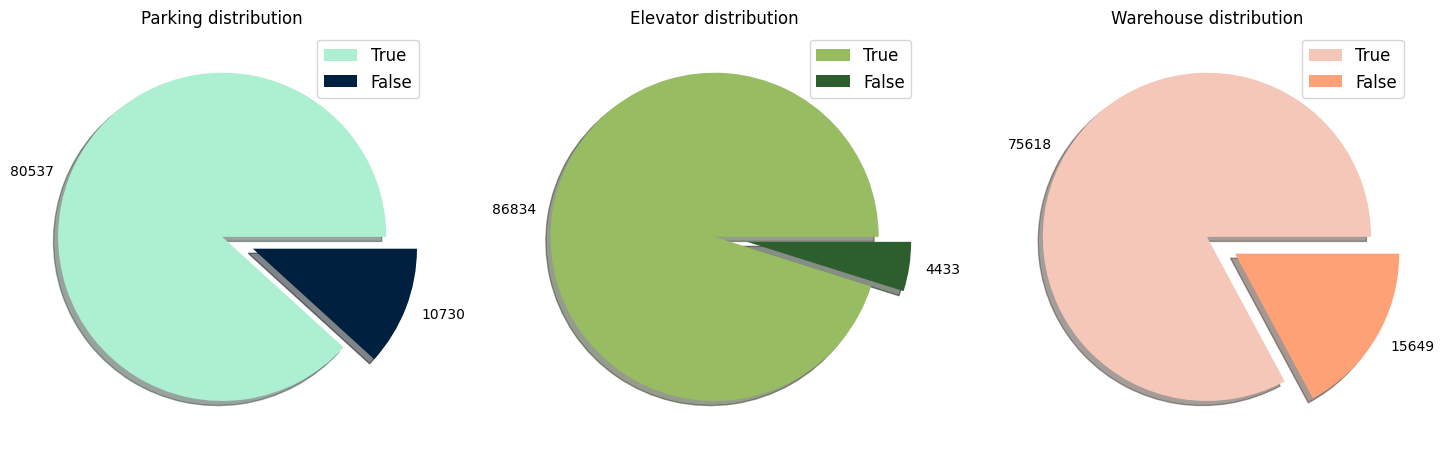

In [68]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Elevator', 'Warehouse']
for i in range(3):
        data = df[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=data.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

According to the data, approximately 87% of the houses in this dataset have parking spaces. Additionally, about 95% of these houses are equipped with elevators, and 81% also include a warehouse. These statistics are visually represented in the chart below.

